In [1]:
import networkx as nx 
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import networkx as nx
import random
import torch
import copy
from torch.distributions.bernoulli import Bernoulli
import pandas as pd

from gsnn.models.GSNN import GSNN
from gsnn.models.NN import NN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.simulate import simulate

from gsnn.reinforce.Actor import Actor
from gsnn.reinforce.Actor import EmbeddedActor
from gsnn.reinforce.Actor import GSNNActor
from gsnn.reinforce.Environment import Environment
from gsnn.reinforce.RewardScaler import RewardScaler
from gsnn.models.GSNN import GSNN
from gsnn.data.LincsDataset import LincsDataset
from gsnn.models import utils 
from gsnn.proc.utils import get_x_drug_conc           # required to unpickle data 
from gsnn.reinforce.Node2Vec import Node2Vec
from gsnn.reinforce.DGI import DGI
from gsnn.reinforce.PPO import PPO

from hnet.models.HyperNet import HyperNet
from hnet.train.hnet import init_hnet

from sklearn.metrics import roc_auc_score

import argparse

# for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/gsnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Using reinforcement learning to learn optimal selection of prior knowledge 

In many cases, prior knowledge is incomplete, noisy or spurrious for specific prediction tasks. In this example, we will demonstrate how we can use the reinforcement learning for the optimal selection of prior knowledge. 

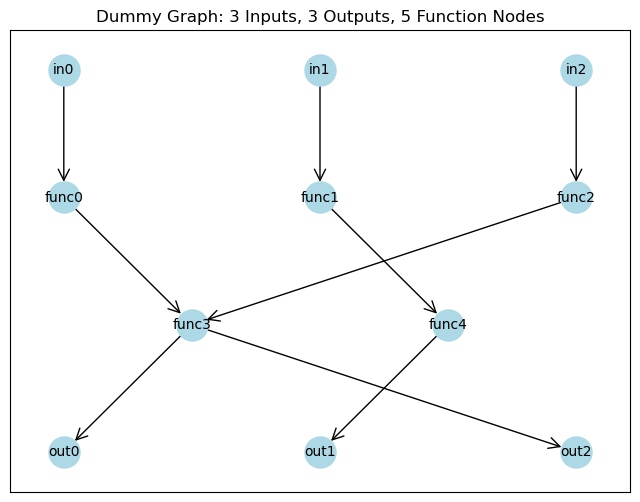

In [2]:
# Create a simple directed graph with 3 inputs, 3 outputs, and 5 function nodes
G = nx.DiGraph()

# Add input nodes, function nodes, and output nodes
input_nodes = ['in0', 'in1', 'in2']
function_nodes = ['func0', 'func1', 'func2', 'func3', 'func4']
output_nodes = ['out0', 'out1', 'out2']

# Add edges from input nodes to function nodes
G.add_edges_from([('in0', 'func0'), ('in1', 'func1'), ('in2', 'func2')])

# Add edges between function nodes
G.add_edges_from([('func0', 'func3'), ('func1', 'func4'), ('func2', 'func3')])

# Add edges from function nodes to output nodes
G.add_edges_from([('func3', 'out0'), ('func4', 'out1'), ('func3', 'out2')])

# Define positions for each node for plotting
pos = {
    'in0': (-2, 2), 'in1': (0, 2), 'in2': (2, 2),
    'func0': (-2, 1), 'func1': (0, 1), 'func2': (2, 1),
    'func3': (-1, 0), 'func4': (1, 0),
    'out0': (-2, -1), 'out1': (0, -1), 'out2': (2, -1)
}

# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

In [3]:
#special_functions = {'func1': lambda x: -np.mean(x), 'func2':lambda x: np.sum([np.exp(xx) for xx in x]), 
#                     'func0': lambda x: np.mean(([(xx-1)**2 for xx in x])), 'func3': lambda x: -np.mean(x) if all([xx > 0 for xx in x]) else np.mean(x)}
special_functions = None

x_train, x_test, y_train, y_test = simulate(G, n_train=500, n_test=500, input_nodes=input_nodes, output_nodes=output_nodes, 
                                            special_functions=special_functions, noise_scale=1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

y_mu = y_train.mean(0); y_std = y_train.std(0)

y_train = (y_train - y_mu)/(y_std + 1e-8)
y_test = (y_test - y_mu)/(y_std + 1e-8)



In [4]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes) 

# add some false edges 
edge_index_dict = copy.deepcopy(data.edge_index_dict)
edge_index_dict['function', 'to', 'function']  = torch.cat((edge_index_dict['function', 'to', 'function'], torch.tensor([[0, 1, 1, 2],
                                                                                                                         [1, 0, 2, 1]], dtype=torch.long)), dim=-1)

In [5]:
# number of possible subgraphs given 7 edges: 
# 2^7 = 128
# altho, an environment run is deterministic and therefore may result in "noisy" rewards

In [6]:
# one hot encode the edges 
x = torch.eye(edge_index_dict['function', 'to', 'function'].size(1), dtype=torch.float32)

In [7]:
# I suspect there is an advantage to having a complex model (many channels) as GSNNs with inaccurate graph structures are more likely to overfit. 
# Since ResNets can be interpreted as ensembles, and ensembles have a regularizing/variance-reducing effect, better to share_layers. 
# along this train of thought -> no dropout 
# also, maybe early stopping is actually detrimental since this is also a sign of overfitting. 
    # maybe just train for X epochs and reward is final perf? or ema ? or auc? 

model_kwargs = {'edge_index_dict'                 : edge_index_dict, 
                    'node_names_dict'                 : data.node_names_dict,
                    'channels'                        : 30, 
                    'layers'                          : 5, 
                    'dropout'                         : 0,
                    'share_layers'                    : True,
                    'add_function_self_edges'         : True,
                    'norm'                            : 'none'}

training_kwargs = {'lr':1e-2, 
                    'max_epochs':50, 
                    'patience':50,
                    'min_delta':1e-4,
                    'batch':100,
                    'workers':5}

args = argparse.Namespace()
args.init_entropy = 1.
args.l1_penalty = 0
args.target_kl = 0.01 # 0.1
args.outer_iters = 25
args.ppo_iters = 1000
args.ppo_batch = 3
args.clip_param = 0.2 # 0.2
args.entropy_decay = 0.5
args.entropy_schedule = 20
args.min_entropy = 0
args.alpha = 0.1

actor = GSNNActor(edge_index_dict, data.node_names_dict, channels=2, layers=3)
#actor = EmbeddedActor(num_actions = edge_index_dict['function', 'to', 'function'].size(1), embed_dim=10)
#actor = Actor(in_channels=x.size(1), model='linear')

optim = torch.optim.Adam(actor.parameters(), lr=1e-3)
env = Environment(torch.utils.data.TensorDataset(x_train, y_train, torch.arange(x_train.size(0))), 
                  torch.utils.data.TensorDataset(x_test, y_test, torch.arange(x_train.size(0))), 
                  None, 
                  model_kwargs, 
                  training_kwargs, 
                  device=device, 
                  metric='spearman')

ppo = PPO(args, clip=10, eps=1e-3, warmup=3, verbose=True)

best_reward = -np.inf
best_action = None

for iter in range(args.outer_iters): 
    optim.zero_grad()

    # compute a batch 
    logits = actor(x).squeeze()
    _actions = [] ; _rewards = []
    for ii in range(args.ppo_batch):
        print(f'[progress: {ii+1}/{args.ppo_batch}]', end='\r')
        m = Bernoulli(logits=logits)
        action = m.sample() 

        rewards = env.run(action, action_type='edge', reward_type='auc', verbose=False)

        if rewards.mean() > best_reward: 
            best_reward = rewards.mean()
            best_action = action.detach().cpu().numpy()

        _actions.append(action) ; _rewards.append(rewards)

    ppo.train_actor(logits, _actions, _rewards, x, actor, optim)
    for r in _rewards: ppo.update(r)

    with torch.no_grad(): 
        action_sum = np.mean([a.sum() for a in _actions])

        edge_probs = actor(x).squeeze().sigmoid().detach().cpu().numpy()
        row, col = edge_index_dict['function','to','function']
        true_edges = set([(i,j) for i,j in zip(*data.edge_index_dict['function','to', 'function'].detach().cpu().numpy())])
        res = pd.DataFrame({'src':row, 'dst':col, 'prob':edge_probs}).assign(true_edge = lambda x: [(i,j) in true_edges for i,j in zip(x.src, x.dst)])
        res = res.assign(ranking=np.argsort(res.prob))

        yhat = res.prob.values
        y = res.true_edge.values
        acc = (1.*((yhat > 0.5) == y)).mean()
        auroc = roc_auc_score(y, yhat)

        batch_reward_mean = np.stack(_rewards).mean()

        print(f'\t\titer: {iter} || perf: {batch_reward_mean:.3f} || acc: {acc:.3f} || auroc {auroc:0.3f}|| # actions: {int(action_sum)}/{len(action)}')


updating best action [reward: 11.379]
updating best action [reward: 15.651]


In [16]:
best_action_acc = (best_action == np.array([1]*3 + [0]*4)).astype(float).mean()
print('best action accuracy:', best_action_acc)

best action accuracy: 0.7142857142857143


In [17]:
edge_probs = actor(x).squeeze().sigmoid().detach().cpu().numpy()
row, col = edge_index_dict['function','to','function']
true_edges = set([(i,j) for i,j in zip(*data.edge_index_dict['function','to', 'function'].detach().cpu().numpy())])
res = pd.DataFrame({'src':row, 'dst':col, 'prob':edge_probs}).assign(true_edge = lambda x: [(i,j) in true_edges for i,j in zip(x.src, x.dst)])
res = res.assign(ranking=np.argsort(res.prob))

In [18]:
yhat = res.prob.values
y = res.true_edge.values
auroc = roc_auc_score(y, yhat)
print('AUROC:', auroc)

AUROC: 0.9166666666666666


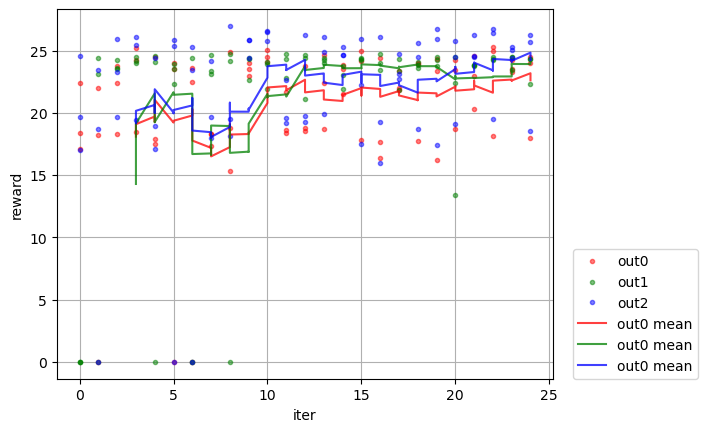

In [19]:
tmp = pd.DataFrame(ppo.rewards, columns=['out0', 'out1', 'out2'])
tmp = tmp.assign(out0_rm = lambda x: x.out0.rolling(10).mean())
tmp = tmp.assign(out1_rm = lambda x: x.out1.rolling(10).mean())
tmp = tmp.assign(out2_rm = lambda x: x.out2.rolling(10).mean())

iters = np.repeat(np.arange(len(ppo.rewards)//args.ppo_batch), args.ppo_batch)

plt.figure()
plt.grid()
plt.plot(iters, [r[0] for r in ppo.rewards], 'r.', alpha=0.5, label='out0')
plt.plot(iters, [r[1] for r in ppo.rewards], 'g.', alpha=0.5, label='out1')
plt.plot(iters, [r[2] for r in ppo.rewards], 'b.', alpha=0.5, label='out2')
plt.plot(iters, tmp.out0_rm, 'r-', alpha=0.75, label='out0 mean')
plt.plot(iters, tmp.out1_rm, 'g-', alpha=0.75, label='out0 mean')
plt.plot(iters, tmp.out2_rm, 'b-', alpha=0.75, label='out0 mean')
plt.legend(loc=(1.04, 0))
plt.ylabel('reward')
plt.xlabel('iter')
plt.show()

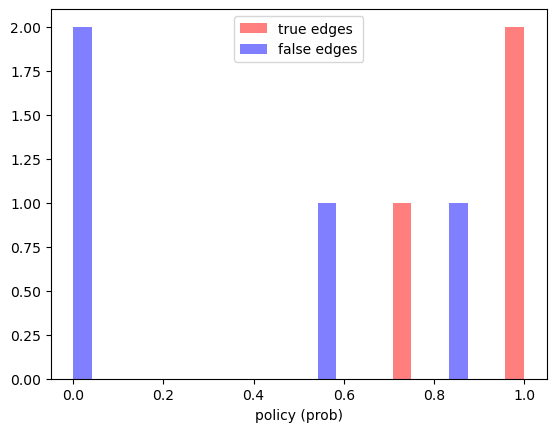

In [20]:
bins = np.linspace(0,1,25)

plt.figure()
plt.hist(res[lambda x: x.true_edge].prob, color='r', alpha=0.5, label='true edges', bins=bins)
plt.hist(res[lambda x: ~x.true_edge].prob, color='b', alpha=0.5, label='false edges', bins=bins)
plt.xlabel('policy (prob)')
plt.legend()
plt.show()